In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
import tensorflow_ranking as tfr

from vae_cf.train import train_epoch
from vae_cf.model import VAE
from vae_cf.data import load_data
from vae_cf.dataset import to_tf_train_dataset, to_tf_eval_dataset

transactions_dir = "/Users/roysung/py_projects/hm_personal_dataset/transactions_train.csv"
tensorboard_dir = "/Users/roysung/py_projects/hm_personal/model_output/basic"

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-12-10 14:23:39.269302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 14:23:39.269412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data

In [ ]:
# Data
tr_data, vd_data, map_dict = load_data(transactions_dir, n_heldout_user=5000)
n_users, n_items = tr_data.shape
vd_features, vd_labels = vd_data

tr_datasets = to_tf_train_dataset(tr_data,  3000, 1)
vd_datasets = to_tf_eval_dataset(vd_features, vd_labels, 1000)

# Parameters
model_params = {
    'p_dims': [200, 600, n_items],
    'q_dims': [n_items, 600, 200],
    'drop_prob': 0.5,
    'l2_reg': 0.0,
    'seed': 98765}
train_params = {
    'metrics': {
        'neg_elbo': tf.keras.metrics.Mean(name='train_neg_elbo'),
        'kl': tf.keras.metrics.Mean(name='train_kl'),
        'neg_ll': tf.keras.metrics.Mean(name='train_neg_ll'),
        'ndcg': tfr.keras.metrics.NDCGMetric(name='test_ndcg', topn=20)},
    'num_epochs': 3,
    'anneal_cap': 0.2,
    'total_anneal_steps': 200000,
    'summary_writer': tf.summary.create_file_writer(tensorboard_dir)}

print(f'n_users_tr: {n_users} / n_items: {n_items} / batch: {n_users / 4000}')
print(f'n_users_vd: {vd_features.shape[0]} / batch: {vd_features.shape[0] / 10000}')

# Model
model = VAE(**model_params)
optimizer = tf.keras.optimizers.Adam(0.001, epsilon=1e-08)
train_epoch(tr_datasets, vd_datasets, model, optimizer, **train_params)

In [30]:
def _to_nd_indices(indices):
    batch_ids = tf.ones_like(indices) * tf.expand_dims(
        tf.range(tf.shape(input=indices)[0]), 1)
    return tf.stack([batch_ids, indices], axis=-1)

scores = tf.cast(labels, tf.float32)

shuffle_ind = None
if True:
    shuffle_ind = _to_nd_indices(
        tf.argsort(
            tf.random.uniform(tf.shape(input=scores), seed=98765),
            stable=True))
    scores = tf.gather_nd(scores, shuffle_ind)
_, indices = tf.math.top_k(scores, 20, sorted=True) # [1000, 20]
nd_indices = _to_nd_indices(indices) # [1000, 20, 2]
nd_indices = tf.gather_nd(shuffle_ind, nd_indices) # [1000, 20, 2]
# tf.gather_nd(labels, nd_indices)

In [16]:
tf.reduce_sum(tf.cast(tf.reduce_sum(scores, axis=1) >= 1, tf.int32))

<tf.Tensor: shape=(), dtype=int32, numpy=691>

## Image Embedding

In [1]:
import pathlib
from tqdm import tqdm

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from skimage.io import imread

from ann import Annoy

BATCH_SIZE = 20
IMAGE_SIZE = (256, 256)
DIMENSION = 1280
data_dir = pathlib.Path("dataset/images/")


def extract_embed(inputs, model):
    outputs = model.predict(preprocess_input(inputs), verbose=0)
    avg_outputs = tf.reduce_mean(outputs, axis=[1, 2])
    return avg_outputs.numpy()


model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
file_names = [f.name[:-4] for f in data_dir.glob("*/*.jpg")]
file_names.sort()
img_datasets = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=file_names,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE)


embed = []
article_map = []
for inputs, labels in tqdm(img_datasets):
    embed.append(extract_embed(inputs, model))
    article_map.append(labels.numpy())

embed = np.reshape(embed, (-1, 1280))
article_map = np.hstack(article_map)
article_map = dict(zip(range(len(article_map)), article_map))

ann_index = Annoy(DIMENSION, mapping=article_map)
ann_index.add_data(embed)
ann_index.build_index()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-10-10 19:38:00.742855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-10 19:38:00.743112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 105100 files belonging to 86 classes.


  0%|          | 0/5255 [00:00<?, ?it/s]2023-10-10 19:38:12.098972: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-10 19:38:12.774506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 5255/5255 [17:47<00:00,  4.92it/s]


<Figure size 640x480 with 0 Axes>

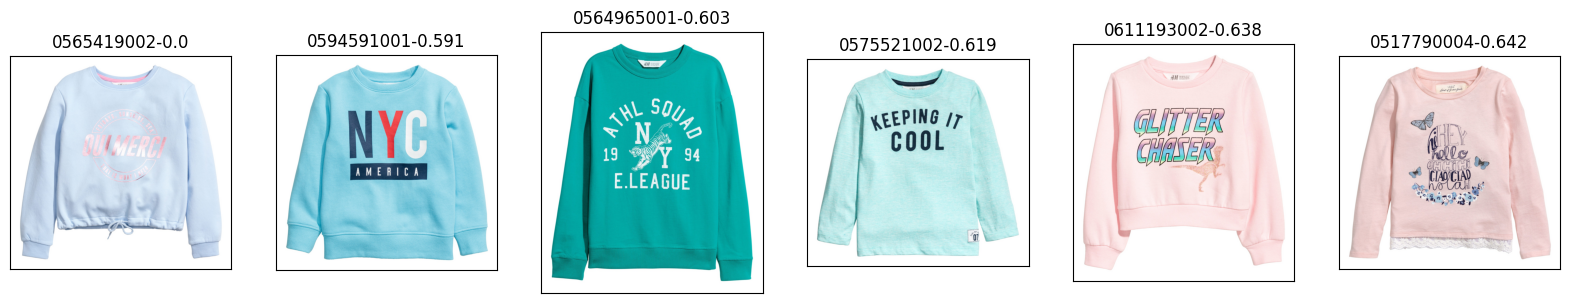

In [42]:
from matplotlib import pyplot as plt
from matplotlib import image as img


top5_image = ann_index.search_vec_top_n(embed[0], 6)

#subplot(r,c) provide the no. of rows and columns
plt.figure()
f, axarr = plt.subplots(1, 6, figsize=(20, 15))

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i, (img_id, img_score) in enumerate(zip(*top5_image)):
    img_id = img_id.decode("utf-8")
    img_score = str(img_score)
    axarr[i].imshow(img.imread(f"dataset/images/{img_id[:3]}/{img_id}.jpg"))
    axarr[i].set_title(f"{img_id}-{img_score[:5]}")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])

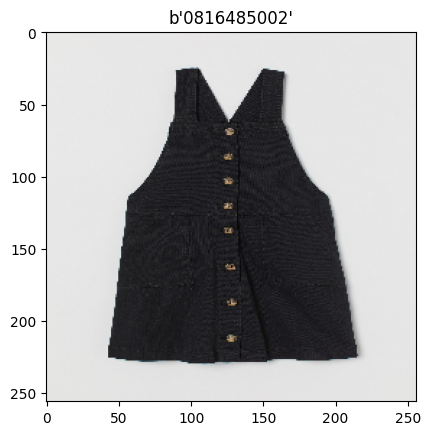

In [5]:
plt.imshow(inputs[12].numpy().astype("uint8"))
plt.title(labels[12].numpy())
plt.show()

## Image Embedding - PyTorch
### Get Embedding

In [1]:
import os
import pickle
from itertools import compress

import numpy as np
import pandas as pd
from fashion_clip.fashion_clip import FashionCLIP


# ---- Data ---- #
articles = pd.read_csv("dataset/articles.csv")
exist_cond = articles['detail_desc'].isna()
articles.loc[exist_cond, 'detail_desc'] = articles.loc[exist_cond, 'prod_name']

images = [f"dataset/images/0{str(img_id)[:2]}/0{str(img_id)}.jpg" for img_id in articles["article_id"].tolist()]
exist_cond = np.array([os.path.exists(path) for path in images])
images = list(compress(images, exist_cond))

# ---- Model ---- #
fclip = FashionCLIP('fashion-clip')

# we create image embeddings and text embeddings
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(articles['detail_desc'].tolist(), batch_size=32)

# we normalize the embeddings to unit norm (so that we can use dot product instead of cosine similarity to do comparisons)
image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

# ---- Saving ---- #
image_id_embed = list(zip(articles.loc[exist_cond, 'article_id'], image_embeddings))
with open('image_embeddings.pickle', 'wb') as f:
    pickle.dump(image_id_embed, f)

text_id_embed = list(zip(articles['article_id'], text_embeddings))
with open('text_embeddings.pickle', 'wb') as f:
    pickle.dump(text_id_embed, f)

/Users/roysung/miniforge3/envs/torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
3285it [1:21:40,  1.49s/it]                          
Map: 100%|██████████| 105542/105542 [00:04<00:00, 22352.07 examples/s]
3299it [18:04,  3.04it/s]                          


### Using Embedding

In [1]:
import pickle
from matplotlib import pyplot as plt
from matplotlib import image as img

import pandas as pd

from ann import Annoy

DIMENSION = 512
IMAGE_W = 0.6


class ClipEmbed:
    def __init__(self, img_w: float, img_path: str, img_e_path: str, text_e_path: str) -> None:
        image_embed = self.__load_embedding(img_e_path, ["article_id", "image_embed"])
        text_embed = self.__load_embedding(text_e_path,["article_id", "text_embed"])
        embed = text_embed.join(image_embed)

        self.img_path = img_path
        self.embed = (1-img_w) * embed["text_embed"] + img_w * embed["image_embed"]

    def show_similar_article(self, target_id: int, top_n: int):
        if not hasattr(self, 'ann_index'):
            self.ann_index = self.__build_ann_index()

        vector = self.embed[target_id]
        top_image = self.ann_index.search_vec_top_n(vector, top_n)

        #subplot(r,c) provide the no. of rows and columns
        plt.figure()
        f, axarr = plt.subplots(1, top_n, figsize=(20, 15))

        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        for i, (img_id, img_score) in enumerate(zip(*top_image)):
            img_id = str(img_id)
            img_score = str(img_score)
            img_path = self.img_path.format(img_id[:2], img_id)

            axarr[i].imshow(img.imread(img_path))
            axarr[i].set_title(f"{img_id}-{img_score[:5]}")
            axarr[i].set_xticks([])
            axarr[i].set_yticks([])

    def __build_ann_index(self):
        n_embed = len(self.embed)
        d_embed = len(self.embed.iloc[0])
        article_map = dict(zip(range(n_embed), self.embed.index))

        ann_index = Annoy(d_embed, mapping=article_map)
        ann_index.add_data(self.embed)
        ann_index.build_index()
        return ann_index

    def __load_embedding(self, path, columns):
        with open(path, 'rb') as f:
            embed_df = pd.DataFrame(pickle.load(f), columns=columns)
            embed_df.set_index(columns[0], inplace=True)
        return embed_df


clip_embed = ClipEmbed(
    IMAGE_W,
    "dataset/images/0{}/0{}.jpg",
    "dataset/image_embeddings.pickle",
    "dataset/text_embeddings.pickle")

<Figure size 640x480 with 0 Axes>

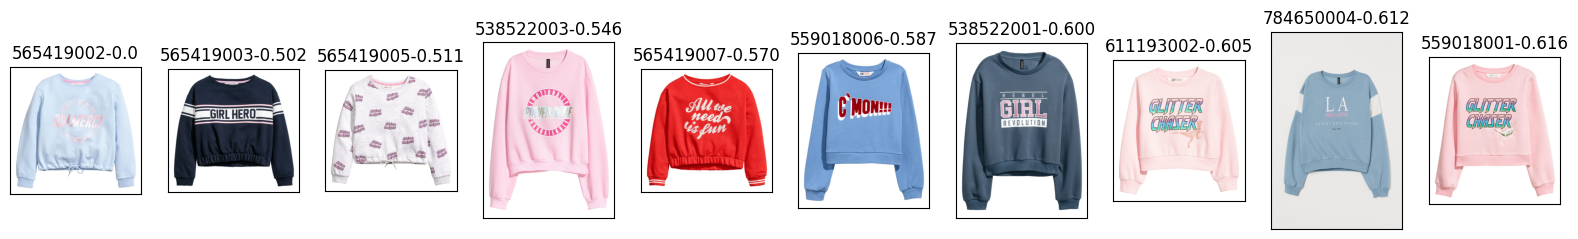

In [2]:
clip_embed.show_similar_article(565419002, 10)

<Figure size 640x480 with 0 Axes>

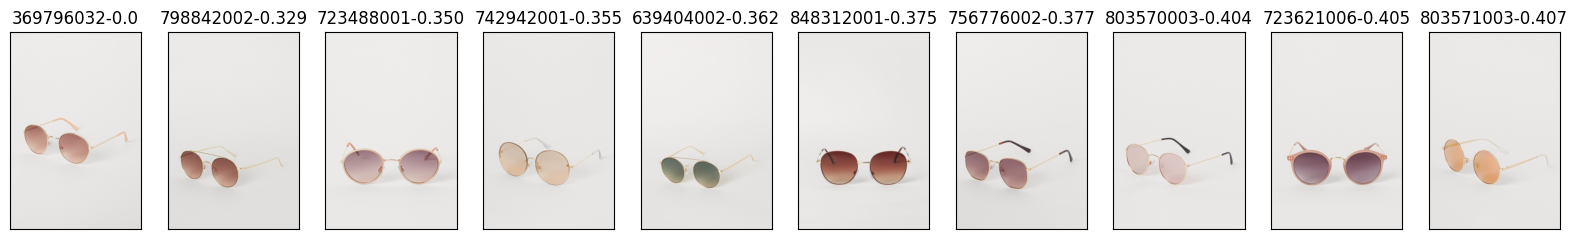

In [3]:
clip_embed.show_similar_article(369796032, 10)

<Figure size 640x480 with 0 Axes>

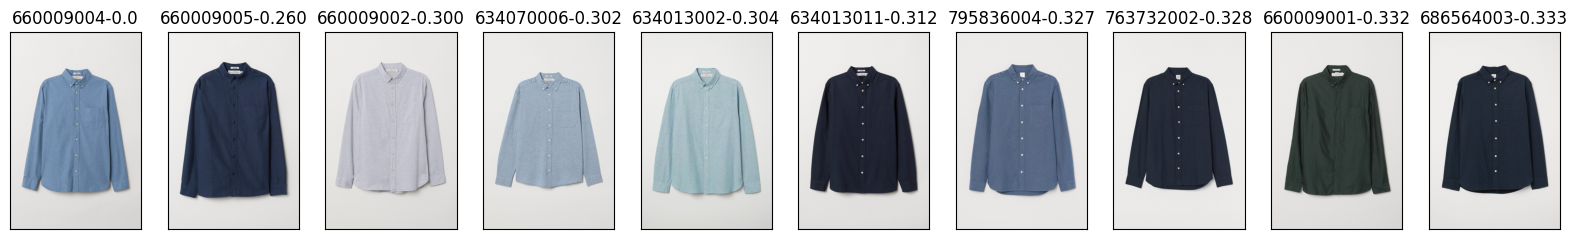

In [5]:
clip_embed.show_similar_article(660009004, 10)

<Figure size 640x480 with 0 Axes>

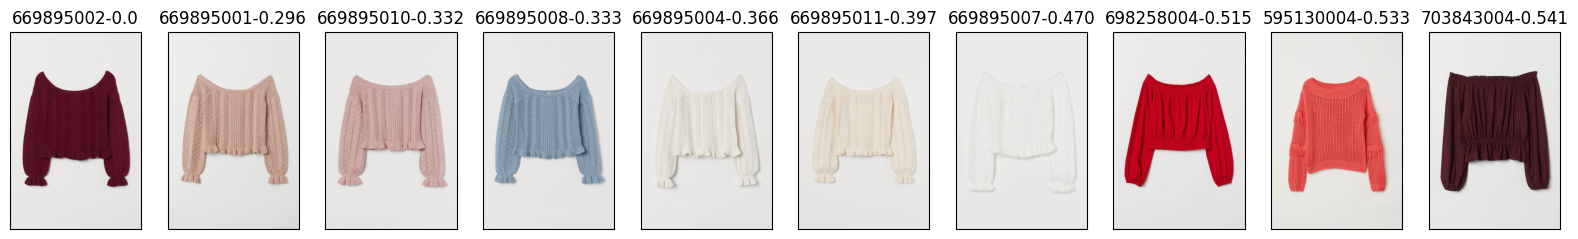

In [6]:
clip_embed.show_similar_article(669895002, 10)